In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import pokemon_gym
from pokemon_gym.pokemon import Pokemon
from pokemon_gym.mab import ContextualEpsilonGreedyBandit

# Simple environment
- 3 possible types: fire, water, grass
- 3 possible moves: one of each type
- Reward: remaining HP of the agent pokemon

In [2]:
# allowed_types = ["fire", "water", "grass"]
pkm = Pokemon().random_pkm()
print(pkm)

grass (100/100) ['fire', 'water', 'grass']


In [4]:
effectiveness_chart = np.array([[1/2, 1/2, 2],
                                [2, 1/2, 1/2],
                                [1/2, 2, 1/2]])

env = gym.make("PokemonBattleEnv-v0", 
               pokemon1=Pokemon().random_pkm(), 
               pokemon2=Pokemon().random_pkm(), 
               effectiveness_chart=effectiveness_chart)

space_size = env.observation_space.n
print("State space:", space_size)

action_size = env.action_space.n
print("Action space:", action_size)

State space: 3
Action space: 3


In [9]:
env.reset()
env.render()

# Simulate an episode
done = False
while not done:
    action = np.random.randint(0, 3)
    obs, reward, done, info = env.step(action)
    env.render()
    print(f"Pokemon 1 attacks Pokemon 2 with a {env.pokemon1.types_map[action]} attack - reward: {reward}")
    if not done:
        print(f"Pokemon 2 attacks Pokemon 1 with a {env.pokemon1.types_map[info['opponent action']]} attack - reward: {reward}")
    else:
        print("Final reward:", reward)
        break

fire (100/100) ['fire', 'water', 'grass'] vs grass (100/100) ['fire', 'water', 'grass']
fire (95/100) ['fire', 'water', 'grass'] vs grass (80/100) ['fire', 'water', 'grass']
Pokemon 1 attacks Pokemon 2 with a fire attack - reward: 1
Pokemon 2 attacks Pokemon 1 with a grass attack - reward: 1
fire (75/100) ['fire', 'water', 'grass'] vs grass (75/100) ['fire', 'water', 'grass']
Pokemon 1 attacks Pokemon 2 with a grass attack - reward: 0
Pokemon 2 attacks Pokemon 1 with a water attack - reward: 0
fire (70/100) ['fire', 'water', 'grass'] vs grass (55/100) ['fire', 'water', 'grass']
Pokemon 1 attacks Pokemon 2 with a fire attack - reward: 1
Pokemon 2 attacks Pokemon 1 with a fire attack - reward: 1
fire (50/100) ['fire', 'water', 'grass'] vs grass (50/100) ['fire', 'water', 'grass']
Pokemon 1 attacks Pokemon 2 with a water attack - reward: 0
Pokemon 2 attacks Pokemon 1 with a water attack - reward: 0
fire (30/100) ['fire', 'water', 'grass'] vs grass (30/100) ['fire', 'water', 'grass']
Pokem

### Multi Armed Bandit

In [10]:
bandit = ContextualEpsilonGreedyBandit(num_arms=action_size, 
                                       num_context=[space_size], 
                                       epsilon=0.1)
print(bandit.q_values.shape)

(3, 3)


In [12]:
num_steps = 1000
reward_history = np.zeros((2,num_steps))
won_battles = np.zeros((2,num_steps))
Q_values = np.zeros((2,3,3))

epsilon = 0.1

for k in range(2):
    
    # Allows comparison between the two reward scenarios
    additional_reward = True if k == 0 else False
    
    env = gym.make("PokemonBattleEnv-v0",
               pokemon1=Pokemon().random_pkm(), 
               pokemon2=Pokemon().random_pkm(), 
               effectiveness_chart=effectiveness_chart,
               additional_reward=additional_reward)
    
    bandit = ContextualEpsilonGreedyBandit(num_arms=action_size,
                                           num_context=[space_size], 
                                           epsilon=epsilon)

    for i in range(num_steps):
        
        done = False
        
        # Simulate changing context (types of Pokémon) for each episode
        env.reset()
        context = env.get_obs()
        
        # Select action based on the context
        chosen_arm = bandit.select_action([context])
        
        while not done:
            _, reward, done, _ = env.step(chosen_arm)
            
        # Update Q-values based on the observed reward and context
        bandit.update_q_values(chosen_arm, [context], reward)
        
        reward_history[k,i] = reward
        won_battles[k,i] = 1 if reward > 0 else 0
    
    Q_values[k,:,:] = bandit.q_values

In [13]:
print("Q values: (actions x opponent type)")
print("\nWith additional reward:")
print(Q_values[0,:,:])
print("\nWithout additional reward:")
print(Q_values[1,:,:])

Q values: (actions x opponent type)

With additional reward:
[[ -4.04397386  -7.20945968  63.42056938]
 [ 64.53001453 -12.8347935   -3.10160214]
 [ -1.18077108  62.37892931  -1.18407243]]

Without additional reward:
[[ 0.          0.         53.73739309]
 [59.29156651  0.          0.        ]
 [ 0.         60.49659547  0.        ]]


In [14]:
print("Win rate:", np.sum(won_battles, axis=1) / num_steps)
print("Average reward:", np.sum(reward_history, axis=1) / num_steps)

Win rate: [0.928 0.863]
Average reward: [58.508 52.03 ]


In [15]:
# print the best move against each type of pokemon
for i in range(3):
    print(f"Best move against {env.pokemon2.types_map[i]} pokemon: {env.pokemon1.types_map[np.argmax(bandit.q_values[:,i])]}")

Best move against fire pokemon: water
Best move against water pokemon: grass
Best move against grass pokemon: fire


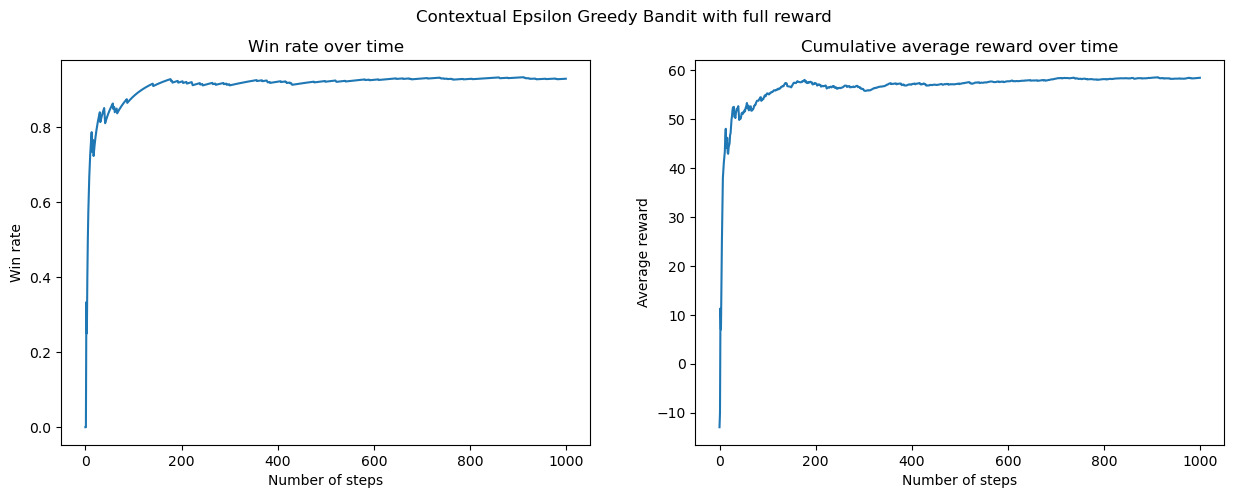

In [16]:
end = num_steps

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Contextual Epsilon Greedy Bandit with full reward')

ax1.plot(np.cumsum(won_battles[0,:end]) / np.arange(1, end + 1))
ax1.set_title('Win rate over time')
ax1.set_xlabel('Number of steps')
ax1.set_ylabel('Win rate')

ax2.plot(np.cumsum(reward_history[0,:end]) / np.arange(1, end + 1))
ax2.set_title('Cumulative average reward over time')
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Average reward')

plt.show()

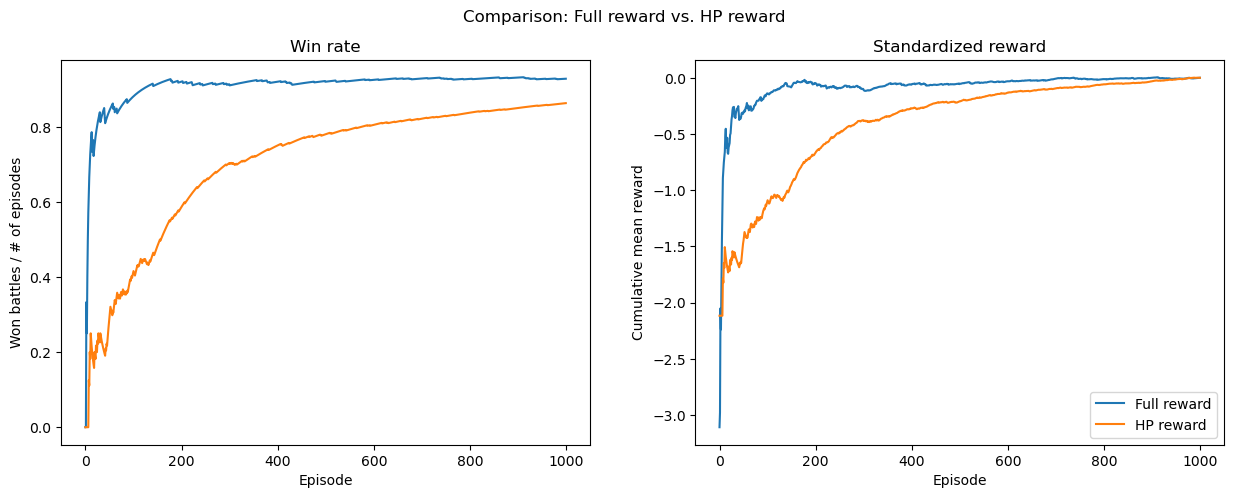

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Comparison: Full reward vs. HP reward')

ax1.plot(np.cumsum(won_battles[0,:end])/np.arange(1,end+1), label="Full reward")
ax1.plot(np.cumsum(won_battles[1,:end])/np.arange(1,end+1), label="HP reward")
ax1.set_title("Win rate")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Won battles / # of episodes")

ax2.plot(np.cumsum((reward_history[0,:end] - np.mean(reward_history[0,:end]))/np.std(reward_history[0,:end]))/np.arange(1,end+1), label="Full reward")
ax2.plot(np.cumsum((reward_history[1,:end] - np.mean(reward_history[1,:end]))/np.std(reward_history[1,:end]))/np.arange(1,end+1), label="HP reward")
ax2.set_title("Standardized reward")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Cumulative mean reward")

plt.legend(loc="lower right")
plt.show()

### Adding normal type

In [2]:
allowed_types = ["normal", "fire", "water", "grass"]

effectiveness_chart = np.array([[1, 1, 1, 1],
                                [1, 1/2, 1/2, 2],
                                [1, 2, 1/2, 1/2],
                                [1, 1/2, 2, 1/2]])

In [19]:
num_steps = 10000
reward_history = np.zeros((2,num_steps))
won_battles = np.zeros((2,num_steps))
Q_values = np.zeros((2,4,4,4))

epsilon = 0.4

for k in range(2):

    additional_reward = True if k == 0 else False
    
    env = gym.make("PokemonBattleEnv-v0",
               pokemon1=Pokemon(allowed_types=allowed_types).random_pkm(), 
               pokemon2=Pokemon(allowed_types=allowed_types).random_pkm(), 
               effectiveness_chart=effectiveness_chart,
               additional_reward=additional_reward)
    
    bandit = ContextualEpsilonGreedyBandit(num_arms=env.action_space.n,
                                           num_context=[env.observation_space.n], 
                                           epsilon=epsilon)
    for i in range(num_steps):
        done = False
        env.reset()
        context = env.get_obs()
        
        chosen_arm = bandit.select_action([context])
        
        while not done:
            _, reward, done, _ = env.step(chosen_arm)
            
        bandit.update_q_values(chosen_arm, [context], reward)
        
        reward_history[k,i] = reward
        won_battles[k,i] = 1 if reward > 0 else 0
        
    Q_values[k,:,:,:] = bandit.q_values

In [21]:
greedy_policy_0 = np.argmax(Q_values[0], axis=1)
greedy_policy_1 = np.argmax(Q_values[1], axis=1)
print("Greedy policy with full reward: (own type x opponent type) ")
print(greedy_policy_0)

print("\nGreedy policy with HP reward: (own type x opponent type)")
print(greedy_policy_1)

print("\nLegend: 0 = normal, 1 = fire, 2 = water, 3 = grass")

Greedy policy with full reward: (own type x opponent type) 
[[3 2 3 1]
 [3 2 3 1]
 [3 2 3 1]
 [3 2 3 1]]

Greedy policy with HP reward: (own type x opponent type)
[[0 2 3 1]
 [0 2 3 1]
 [0 2 3 1]
 [0 2 3 1]]

Legend: 0 = normal, 1 = fire, 2 = water, 3 = grass


### Additional damage and reward if the move is of the same type as the pokemon

In [8]:
optimal_policy = np.array([[0, 2, 3, 1],
                           [1, 2, 3, 1],
                           [2, 2, 3, 1],
                           [3, 2, 3, 1]])

In [27]:
num_steps = 10000
reward_history = np.zeros((2,num_steps))
won_battles = np.zeros((2,num_steps))
Q_values = np.zeros((2,4,4,4))

epsilon = 0.3

for k in range(2):

    additional_reward = True if k == 0 else False
    
    env = gym.make("PokemonBattleEnv-v1",
               pokemon1=Pokemon(allowed_types=allowed_types).random_pkm(), 
               pokemon2=Pokemon(allowed_types=allowed_types).random_pkm(), 
               effectiveness_chart=effectiveness_chart,
               additional_reward=additional_reward,
               selftype_dmg = True)
    
    bandit = ContextualEpsilonGreedyBandit(num_arms=env.action_space.n,
                                           num_context=[space.n for space in env.observation_space.spaces], 
                                           epsilon=epsilon)
    for i in range(num_steps):
        done = False
        context = env.reset()
        
        chosen_arm = bandit.select_action(context)
        
        while not done:
            _, reward, done, _ = env.step(chosen_arm)
            
        bandit.update_q_values(chosen_arm, context, reward)
        
        reward_history[k,i] = reward
        won_battles[k,i] = 1 if reward > 0 else 0
        
    Q_values[k,:,:,:] = bandit.q_values

In [28]:
greedy_policy_0 = np.argmax(Q_values[0], axis=0)
greedy_policy_1 = np.argmax(Q_values[1], axis=0)

print("Greedy policy with full reward: (own type x opponent type) ")
print(greedy_policy_0)

print("\nGreedy policy with HP reward: (own type x opponent type)")
print(greedy_policy_1)

Greedy policy with full reward: (own type x opponent type) 
[[0 0 3 0]
 [1 2 3 1]
 [2 2 3 2]
 [1 0 3 1]]

Greedy policy with HP reward: (own type x opponent type)
[[0 2 3 1]
 [2 2 0 1]
 [3 2 3 1]
 [3 3 3 1]]


In [29]:
for i in range(4):
    for j in range(4):
        print(f"{env.pokemon1.types_map[j]} vs {env.pokemon2.types_map[i]}: {env.pokemon1.types_map[greedy_policy_0[j,i]]} (correct: {env.pokemon1.types_map[optimal_policy[j,i]]})")

normal vs normal: normal (correct: normal)
fire vs normal: fire (correct: fire)
water vs normal: water (correct: water)
grass vs normal: fire (correct: grass)
normal vs fire: normal (correct: water)
fire vs fire: water (correct: water)
water vs fire: water (correct: water)
grass vs fire: normal (correct: water)
normal vs water: grass (correct: grass)
fire vs water: grass (correct: grass)
water vs water: grass (correct: grass)
grass vs water: grass (correct: grass)
normal vs grass: normal (correct: fire)
fire vs grass: fire (correct: fire)
water vs grass: water (correct: fire)
grass vs grass: fire (correct: fire)


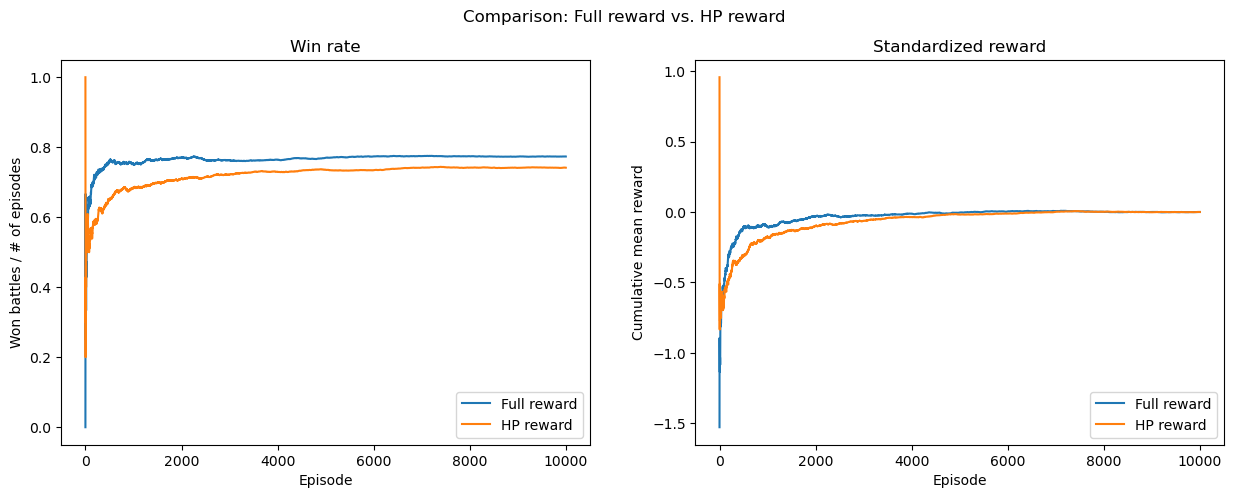

In [31]:
end = num_steps

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Comparison: Full reward vs. HP reward')

ax1.plot(np.cumsum(won_battles[0,:end])/np.arange(1,end+1), label="Full reward")
ax1.plot(np.cumsum(won_battles[1,:end])/np.arange(1,end+1), label="HP reward")
ax1.set_title("Win rate")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Won battles / # of episodes")
ax1.legend(loc="lower right")

ax2.plot(np.cumsum((reward_history[0,:end] - np.mean(reward_history[0,:end]))/np.std(reward_history[0,:end]))/np.arange(1,end+1), label="Full reward")
ax2.plot(np.cumsum((reward_history[1,:end] - np.mean(reward_history[1,:end]))/np.std(reward_history[1,:end]))/np.arange(1,end+1), label="HP reward")
ax2.set_title("Standardized reward")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Cumulative mean reward")
ax2.legend(loc="lower right")

plt.show()

### Random vs Random perfect

- Random: randomly select a move from the available moves
- Random perfect: select a random move with 0.5 probability, otherwise select the move that is super effective against the opponent's type

In [8]:
num_steps = 10000
reward_history = np.zeros((2,num_steps))
won_battles = np.zeros((2,num_steps))
Q_values = np.zeros((2,4,4,4))

epsilon = 0.4  # Exploration-exploitation trade-off parameter

for k in range(2):
    
    opponent = "random" if k == 0 else "random_perfect"
    
    env = gym.make("PokemonBattleEnv-v0",
               pokemon1=Pokemon(allowed_types=allowed_types).random_pkm(), 
               pokemon2=Pokemon(allowed_types=allowed_types).random_pkm(), 
               effectiveness_chart=effectiveness_chart,
               additional_reward=True,
               opponent=opponent)
    
    bandit = ContextualEpsilonGreedyBandit(num_arms=env.action_space.n,
                                           num_context=env.observation_space.n, 
                                           epsilon=epsilon)
    for i in range(num_steps):
        done = False
        env.reset()
        context = env.get_obs()
        
        chosen_arm = bandit.select_action(context)
        
        while not done:
            _, reward, done, _ = env.step(chosen_arm)
            
        bandit.update_q_values(chosen_arm, context, reward)
        reward_history[k,i] = reward
        won_battles[k,i] = 1 if reward > 0 else 0
        
    Q_values[k,:,:,:] = bandit.q_values

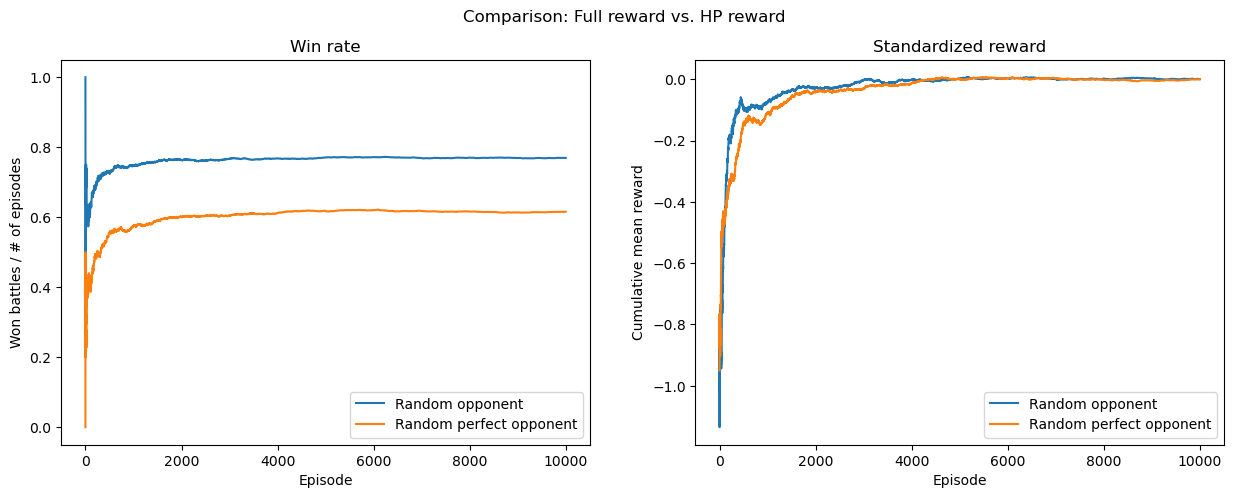

In [17]:
end = num_steps

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Comparison: Full reward vs. HP reward')

ax1.plot(np.cumsum(won_battles[0,:end])/np.arange(1,end+1), label="Random opponent")
ax1.plot(np.cumsum(won_battles[1,:end])/np.arange(1,end+1), label="Random perfect opponent")
ax1.set_title("Win rate")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Won battles / # of episodes")
ax1.legend(loc='lower right')

ax2.plot(np.cumsum((reward_history[0,:end] - np.mean(reward_history[0,:end]))/np.std(reward_history[0,:end]))/np.arange(1,end+1), label="Random opponent")
ax2.plot(np.cumsum((reward_history[1,:end] - np.mean(reward_history[1,:end]))/np.std(reward_history[1,:end]))/np.arange(1,end+1), label="Random perfect opponent")
ax2.set_title("Standardized reward")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Cumulative mean reward")
ax2.legend(loc='lower right')

plt.show()